<a href="https://colab.research.google.com/github/alialdakheel/phareq_model/blob/main/training/train_custom1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Train simple vision model for phishing detection

## Mount and extract

In [1]:
from google.colab import drive
drive.mount('./gdrive')

Mounted at ./gdrive


In [2]:
!unzip -q ./gdrive/MyDrive/phi_dataset.zip -d /content

## Imports

In [3]:
import numpy as np
import os
import pathlib
import PIL
import PIL.Image
import tensorflow as tf

from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential

In [4]:
dataset_dir = pathlib.Path("./phi_dataset/")
model_dir = pathlib.Path('./gdrive/MyDrive/phi_models/')
checkpoint_dir = pathlib.Path('./gdrive/MyDrive/phi_checkpoints/')

In [5]:
os.listdir(dataset_dir)

['phishing', 'trusted_list']

In [6]:
import datetime
date = datetime.datetime.now()
date = '_'.join(str(date).split())
print(date)

2021-07-23_10:41:26.182203


## Params

In [7]:
model_name = "custom1"
batch_size = 16
img_height = 256
img_width = 512 

## Load dataset

In [8]:
train_ds = tf.keras.preprocessing.image_dataset_from_directory(
  dataset_dir,
  validation_split=0.2,
  subset="training",
  label_mode = 'binary',
  seed=132,
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 10541 files belonging to 2 classes.
Using 8433 files for training.


In [9]:
rest_ds = tf.keras.preprocessing.image_dataset_from_directory(
  dataset_dir,
  validation_split=0.2,
  subset="validation",
  label_mode='binary',
  seed=132,
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 10541 files belonging to 2 classes.
Using 2108 files for validation.


In [10]:
val_ds = rest_ds.skip(int(2108 * 0.5 // batch_size))
test_ds = rest_ds.take(int(2108 * 0.5 // batch_size))

In [11]:
class_names = train_ds.class_names

In [12]:
class_names

['phishing', 'trusted_list']

## Visualize data

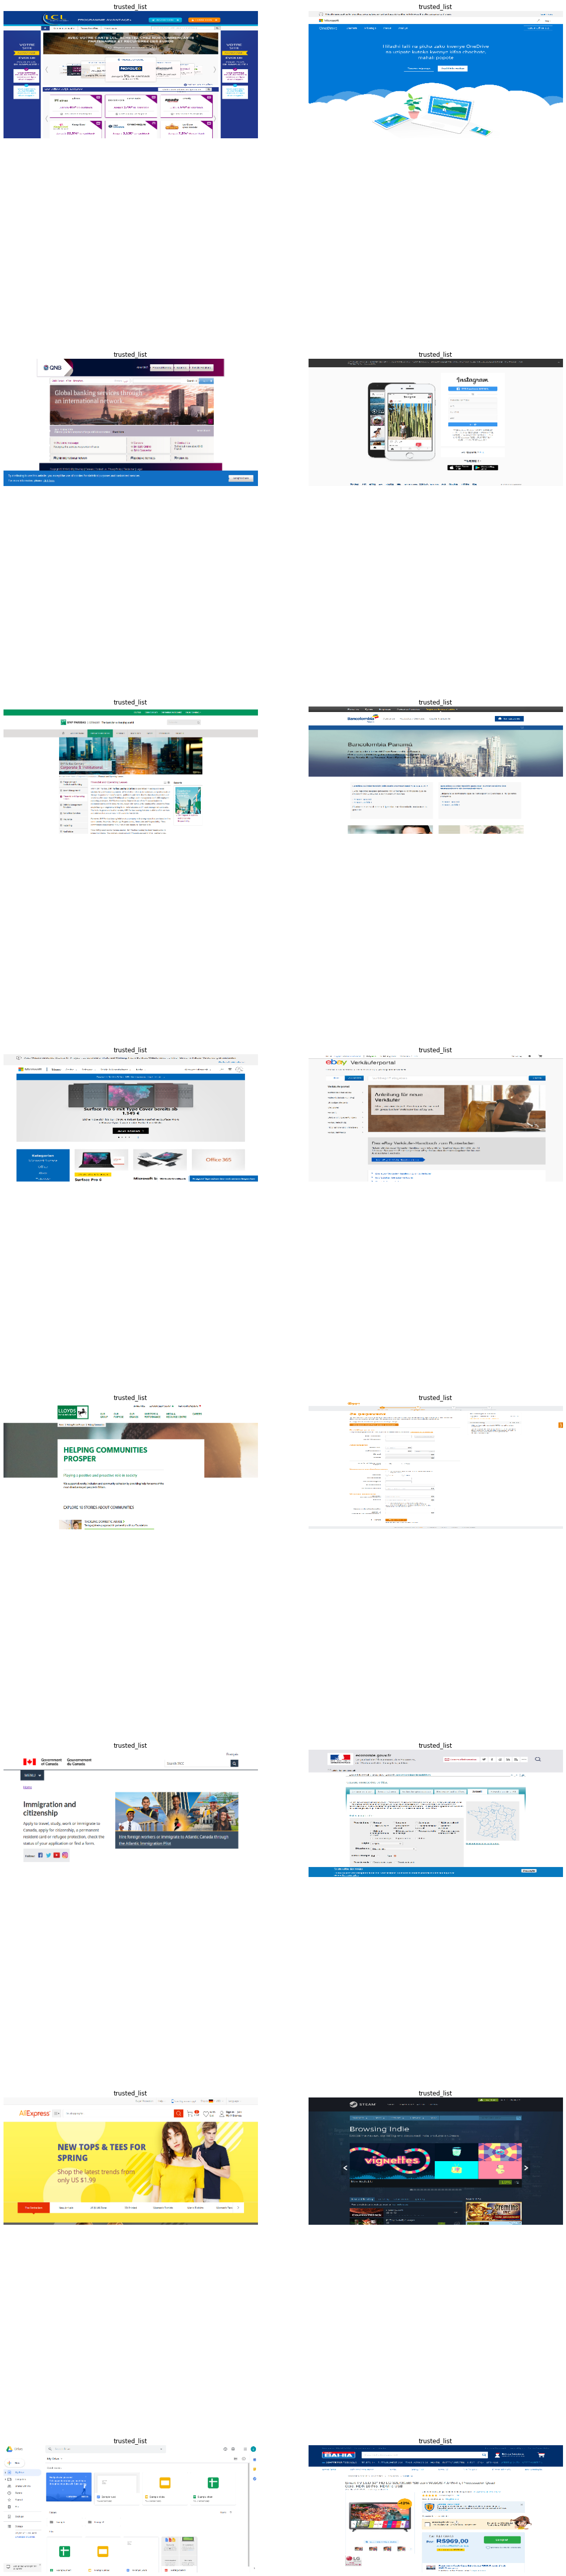

In [14]:
import matplotlib.pyplot as plt
plt.figure(figsize=(20, 100))
for images, labels in train_ds.take(1):
  for i in range(16):
    ax = plt.subplot(8, 2, i + 1)
    plt.imshow(images[i].numpy().astype("uint8"))
    plt.title(class_names[int(labels[i])])
    plt.axis("off")

## Tune dataset

In [15]:
AUTOTUNE = tf.data.AUTOTUNE

train_ds = train_ds.cache().shuffle(512).prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)
test_ds = test_ds.cache().prefetch(buffer_size=AUTOTUNE)

##Standardize the data

TODO: check if including all preprocessing in the model layers is better from deployment point of view.

In [ ]:
# normalization_layer = layers.experimental.preprocessing.Rescaling(1./255)


In [ ]:
# normalized_ds = train_ds.map(lambda x, y: (normalization_layer(x), y))
# image_batch, labels_batch = next(iter(normalized_ds))
# first_image = image_batch[0]
# # Notice the pixels values are now in `[0,1]`.
# print(np.min(first_image), np.max(first_image))


## Model

In [13]:
num_classes = 2

model = Sequential([
  layers.experimental.preprocessing.Rescaling(1./255, input_shape=(img_height, img_width, 3)),
  layers.Conv2D(16, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(32, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(64, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Flatten(),
  layers.Dense(128, activation='relu'),
  layers.Dense(num_classes-1)
])


In [14]:
model.compile(optimizer='adam',
              loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
              metrics=['accuracy'])


In [15]:
model.summary()


Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
rescaling (Rescaling)        (None, 256, 512, 3)       0         
_________________________________________________________________
conv2d (Conv2D)              (None, 256, 512, 16)      448       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 128, 256, 16)      0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 128, 256, 32)      4640      
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 64, 128, 32)       0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 64, 128, 64)       18496     
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 32, 64, 64)        0

## Training

In [16]:
callbacks = [
    keras.callbacks.ModelCheckpoint(
        # Path where to save the model
        # The two parameters below mean that we will overwrite
        # the current checkpoint if and only if
        # the `val_loss` score has improved.
        # The saved model name will include the current epoch.
        filepath=checkpoint_dir / f"{date}_{model_name}_valacc{{val_accuracy:.4f}}_e{{epoch}}",
        save_best_only=True,  # Only save a model if `val_loss` has improved.
        monitor="val_loss",
        verbose=1,
    ),
    keras.callbacks.EarlyStopping(
        # Stop training when `val_loss` is no longer improving
        monitor="val_loss",
        # "no longer improving" being defined as "no better than 1e-2 less"
        min_delta=1e-2,
        # "no longer improving" being further defined as "for at least 2 epochs"
        patience=2,
        verbose=1,
    )
]


In [17]:
epochs=10
history = model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs,
  callbacks=callbacks
)

Epoch 1/10
528/528 [==============================] - 449s 780ms/step - loss: 0.3287 - accuracy: 0.8777 - val_loss: 0.2704 - val_accuracy: 0.8979

Epoch 00001: val_loss improved from inf to 0.27038, saving model to gdrive/MyDrive/phi_checkpoints/2021-07-23_10:41:26.182203_custom1_valacc0.8979_e1
INFO:tensorflow:Assets written to: gdrive/MyDrive/phi_checkpoints/2021-07-23_10:41:26.182203_custom1_valacc0.8979_e1/assets
Epoch 2/10
528/528 [==============================] - 417s 780ms/step - loss: 0.2156 - accuracy: 0.9118 - val_loss: 0.2185 - val_accuracy: 0.9110

Epoch 00002: val_loss improved from 0.27038 to 0.21846, saving model to gdrive/MyDrive/phi_checkpoints/2021-07-23_10:41:26.182203_custom1_valacc0.9110_e2
INFO:tensorflow:Assets written to: gdrive/MyDrive/phi_checkpoints/2021-07-23_10:41:26.182203_custom1_valacc0.9110_e2/assets
Epoch 3/10
528/528 [==============================] - 418s 782ms/step - loss: 0.1231 - accuracy: 0.9496 - val_loss: 0.4249 - val_accuracy: 0.9120

Epoch 0

## Save model

In [27]:
val_acc = history.history['val_accuracy']
model.save(model_dir / f"{date}_{model_name}_valacc{val_acc[-1]:0.4f}_e{len(val_acc)}_b{batch_size}.tf",
           include_optimizer=True)

INFO:tensorflow:Assets written to: gdrive/MyDrive/phi_models/2021-07-23_10:41:26.182203_custom1_valacc0.9185_e4_b16.tf/assets


## Load model

In [ ]:
model2 = keras.models.load_model(
    model_dir / f"2021-07-22_18:06:01.603542_custom1_valacc0.91_e4_b16.tf",
    compile=True)

## Visulaize loss and acc

In [24]:
history.history

{'accuracy': [0.8777422308921814,
  0.9117751717567444,
  0.9496027231216431,
  0.9734376668930054],
 'loss': [0.32869982719421387,
  0.21561351418495178,
  0.12310874462127686,
  0.06818054616451263],
 'val_accuracy': [0.8979400992393494,
  0.9110487103462219,
  0.9119850397109985,
  0.9185393452644348],
 'val_loss': [0.2703832685947418,
  0.2184591293334961,
  0.42490389943122864,
  0.42849695682525635]}

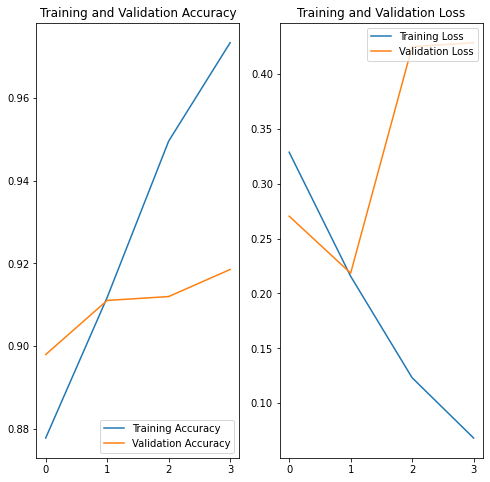

In [23]:
import matplotlib.pyplot as plt

acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

# epochs_range = range(epochs)
epochs_range = history.epoch

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()


## Evaluate (test)

In [20]:
results = model.evaluate(test_ds, batch_size=32)
print("test loss, test acc:", results)


65/65 [==============================] - 33s 451ms/step - loss: 0.3877 - accuracy: 0.9308
test loss, test acc: [0.3876546621322632, 0.9307692050933838]
